This script extends the pipeline to IFRS‑9 lifetime ECL with macro scenarios and PD term structures. It’s self‑contained: it generates synthetic data, trains a PD model, builds PIT PD term structures per scenario, computes Stage 1 vs Stage 2/3 ECL (with SICR logic), discounts expected losses using EIR, and exports plots + an Excel report.

### Notes & simplifications (all adjustable in the code):

- PD term structure: derived from a base 12‑month PD via a monthly hazard rate, scaled over time by scenario multipliers (Baseline/Adverse/Severe).
- SICR (significant increase in credit risk): Stage 2 if (current 12m PD / orig 12m PD) ≥ 2× or absolute 12m PD ≥ 5%. Stage 3 if flagged default.
- EAD: monthly amortization + optional CCF on undrawn (higher for Stage 2/3).
- LGD: base (e.g., 45%) with downturn multipliers by scenario.
- Discounting: uses account EIR (set equal to the contractual interest rate here) for PV of expected cash shortfalls.
  
### What this produces
- PD (12m) model with AUC + calibration
- Scenario PIT PD term structures (monthly to 5 years, adjustable)
- Stage allocation (1/2/3) per account via SICR rules
- Lifetime ECL per account and portfolio, scenario-weighted
- Plots: Stage mix, ECL by scenario, PD term structure
- Excel report with all key tables


Run timestamp: 2025-09-01T17:14:18.601444

Accounts (test): 587
PD model AUC (12m): 0.6827

Scenario weights: Baseline=0.60, Adverse=0.30, Severe=0.10
Staging: Stage 2 if PD12 >= 5.00% OR PD12(current)/PD12(orig) >= 2.0; Stage 3 if default flagged.

Files created:
- .\IFRS9_Lifetime_ECL_Report.xlsx
- .\stage_distribution.png
- .\ecl_by_scenario.png
- .\cum_default_paths.png
- .\roc_curve_pd12.png
- .\calibration_pd12.png



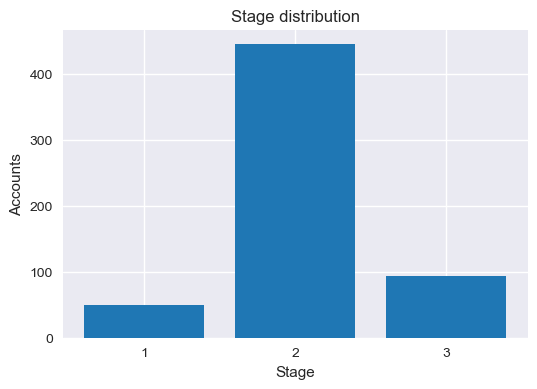

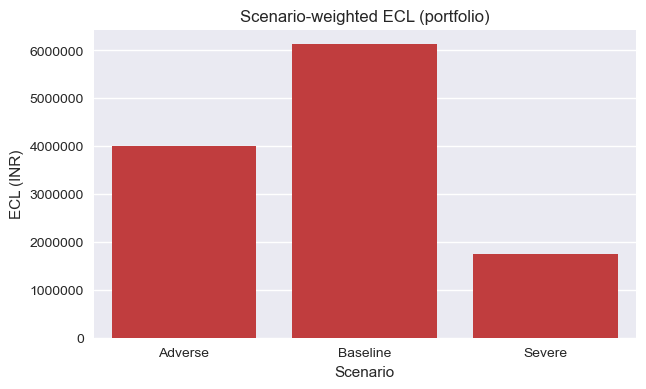

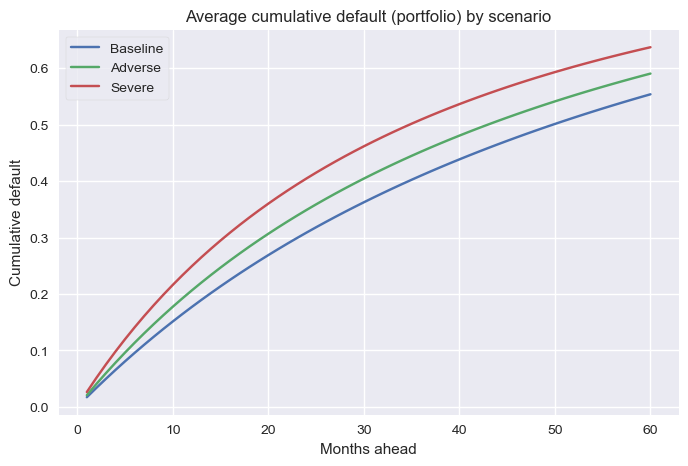

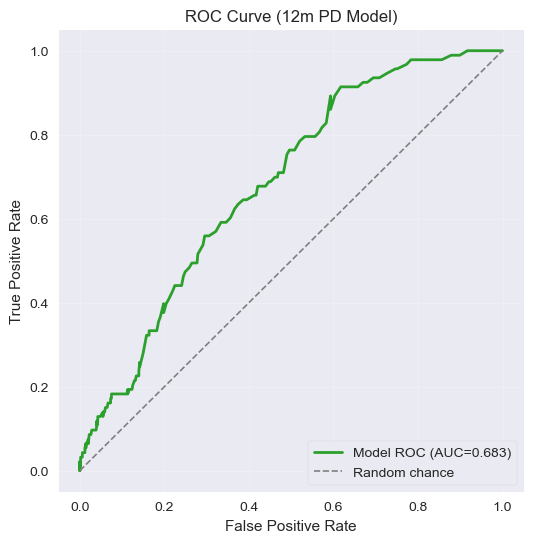

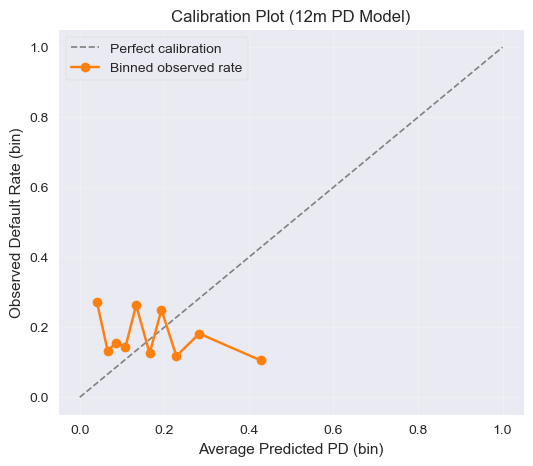

In [10]:
# ifrs9_lifetime_ecl_pipeline.py
# -----------------------------------------------------------
# IFRS-9 Lifetime ECL with macro scenarios & PD term structures
# - Synthetic data + Logistic PD model (12m PD)
# - PIT PD term structures via monthly hazard scaled by scenarios
# - SICR staging (Stage 1 vs Stage 2/3)
# - EAD schedule (amortization + optional CCF)
# - LGD downturn by scenario
# - ECL = sum_t[ mPD_t * EAD_t * LGD_t / (1+EIR)^(t/12) ] across scenarios
# - Plots (saved AND displayed) and Excel report
# -----------------------------------------------------------

import os
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -----------------------------
# 0) CONFIG
# -----------------------------
np.random.seed(42)

OUTPUT_DIR = "."              # where to save outputs
PLOT_DPI = 150
SHOW_PLOTS = True             # display plots as windows when you run the script

# Modeling scope
N_ACCOUNTS = 2000
MAX_HORIZON_MONTHS = 60       # lifetime horizon cap (adjust as needed)

# PD/EAD/LGD settings
ASSUMED_LGD = 0.45
CCF_S1 = 0.30                 # Stage 1 credit conversion on undrawn
CCF_S23 = 0.50                # Stage 2/3 credit conversion on undrawn

# SICR rules (illustrative)
SICR_PD_MULTIPLE = 2.0        # current 12m PD / orig 12m PD >= 2 -> Stage 2
SICR_ABS_PD = 0.05            # absolute 12m PD >= 5% -> Stage 2
STAGE3_PD_HARD_FLAG = None    # keep None; Stage 3 driven by default flag only in this demo

# Scenarios (weights sum to 1)
SCENARIOS = [
    {"name": "Baseline", "weight": 0.60, "pd_mult_path": None, "lgd_mult": 1.00},
    {"name": "Adverse",  "weight": 0.30, "pd_mult_path": None, "lgd_mult": 1.20},
    {"name": "Severe",   "weight": 0.10, "pd_mult_path": None, "lgd_mult": 1.40},
]

# -----------------------------
# 1) Synthetic data
# -----------------------------
def gen_synthetic_credit_data(n=N_ACCOUNTS):
    credit_score  = np.clip(np.round(np.random.normal(680, 70, n)), 300, 850)
    loan_amount   = np.clip(np.round(np.random.lognormal(mean=11.0, sigma=0.7, size=n)), 5e4, 1e7)
    tenure_months = np.random.randint(12, 121, size=n)  # 1–10 years
    interest_rate = np.round(np.random.uniform(0.06, 0.24, size=n), 4)
    utilization   = np.round(np.random.uniform(0.3, 1.0, size=n), 3)
    limit_amount  = np.round(loan_amount / np.maximum(utilization, 0.01))

    # Latent PD just to generate a realistic default_flag label
    x_score = (700 - credit_score) / 100.0
    x_amt   = np.log(loan_amount) - np.log(2e5)
    x_ten   = (tenure_months - 36) / 12.0
    x_rate  = (interest_rate - 0.12) * 10
    x_util  = (utilization  - 0.7) * 2
    linpred = -2.2 + 0.8*x_score + 0.25*x_amt + 0.15*x_ten + 0.4*x_rate + 0.5*x_util
    true_pd = 1.0 / (1.0 + np.exp(-linpred))
    default_flag = (np.random.uniform(size=n) < true_pd).astype(int)

    return pd.DataFrame({
        'counterparty_id': [f'C{i:05d}' for i in range(1, n+1)],
        'credit_score':    credit_score.astype(int),
        'loan_amount':     loan_amount.astype(float),
        'limit_amount':    limit_amount.astype(float),
        'tenure_months':   tenure_months.astype(int),
        'interest_rate':   interest_rate.astype(float),
        'utilization':     utilization.astype(float),
        'default_flag':    default_flag.astype(int),
        'true_pd':         true_pd
    })

# -----------------------------
# 2) PD model (12-month PD via Logit)
# -----------------------------
def prepare_features(df):
    df = df.copy()
    df['log_loan_amt']   = np.log(df['loan_amount'])
    df['rate_pct']       = df['interest_rate'] * 100
    df['score_centered'] = df['credit_score'] - 700
    X = sm.add_constant(df[['score_centered','log_loan_amt','tenure_months','rate_pct','utilization']])
    y = df['default_flag'].astype(int)
    return X, y

def fit_logit(X, y):
    return sm.Logit(y, X).fit(disp=False)

def predict_pd12(model, X):
    return model.predict(X)  # 12m PD estimate (PIT proxy)

# -----------------------------
# 3) Scenario PD term structure utilities
# -----------------------------
def constant_monthly_hazard_from_12m(pd12):
    """ 1 - exp(-12h) = pd12  ->  h = -ln(1 - pd12)/12 """
    pd12 = np.clip(pd12, 1e-8, 1 - 1e-8)
    return -np.log(1.0 - pd12) / 12.0

def build_pd_multiplier_paths(T=MAX_HORIZON_MONTHS):
    """Illustrative multiplier paths by scenario."""
    t = np.arange(1, T+1)
    baseline = 1.03 - 0.03 * (t-1)/(T-1)      # -> 1.00
    adverse  = 1.25 - 0.20 * (t-1)/(T-1)      # -> 1.05
    severe   = 1.60 - 0.50 * (t-1)/(T-1)      # -> 1.10
    return baseline, adverse, severe

def hazard_curve_from_pd12_and_multipliers(pd12_vec, mult_path):
    """Outer product to get [N, T] hazard surface from base monthly hazard and multipliers."""
    h0 = constant_monthly_hazard_from_12m(np.asarray(pd12_vec))   # [N]
    return np.outer(h0, mult_path)                                # [N, T]

def survival_and_marginal_default(hazard_curve):
    """
    Given hazard h_t (shape: [N, T]), compute survival S_t and marginal default mPD_t.
    S_t = exp(-sum_{k=1..t} h_k), S_0=1
    mPD_t = S_{t-1} * (1 - exp(-h_t))
    """
    h = np.atleast_2d(hazard_curve)
    N, T = h.shape
    S = np.ones((N, T+1))
    for t in range(1, T+1):
        S[:, t] = S[:, t-1] * np.exp(-h[:, t-1])
    mPD = S[:, :-1] * (1.0 - np.exp(-h))
    return S[:, 1:], mPD

# -----------------------------
# 4) EAD & LGD paths
# -----------------------------
def amortization_balance_path(loan_amt, tenure_m, T):
    """Linear amortization monthly; clamp to zero after maturity."""
    t = np.arange(1, T+1)
    frac = np.clip(1.0 - t / max(int(tenure_m), 1), 0.0, 1.0)
    return loan_amt * frac

def ead_path(loan_amt, limit_amt, tenure_m, T, stage, ccf_s1=CCF_S1, ccf_s23=CCF_S23):
    """
    EAD_t = balance_t + CCF * undrawn_t, undrawn_t = max(limit - balance_t, 0)
    Higher CCF for Stage 2/3 (prudence).
    """
    bal     = amortization_balance_path(loan_amt, tenure_m, T)
    undrawn = np.maximum(limit_amt - bal, 0.0)
    ccf     = ccf_s23 if stage in (2, 3) else ccf_s1
    return bal + ccf * undrawn

def lgd_path(base_lgd, T, lgd_mult):
    return np.full(T, base_lgd * lgd_mult, dtype=float)

def discount_factors(eir, T):
    """Monthly discount factors using EIR (here proxy = contractual rate)."""
    t = np.arange(1, T+1)
    return 1.0 / np.power(1.0 + float(eir), t/12.0)

# -----------------------------
# 5) SICR and staging
# -----------------------------
def compute_stage(current_pd12, orig_pd12, default_flag,
                  sicr_multiple=SICR_PD_MULTIPLE, sicr_abs=SICR_ABS_PD,
                  stage3_pd_threshold=STAGE3_PD_HARD_FLAG):
    if int(default_flag) == 1 or (stage3_pd_threshold is not None and current_pd12 >= stage3_pd_threshold):
        return 3
    if (current_pd12 >= sicr_abs) or (orig_pd12 > 0 and (current_pd12 / orig_pd12) >= sicr_multiple):
        return 2
    return 1

# -----------------------------
# 6) Plot helpers (save + optional show)
# -----------------------------
_open_figs = []  # store figures to show later

def save_plot(fig, path, show=SHOW_PLOTS):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    fig.savefig(path, dpi=PLOT_DPI)
    if show:
        _open_figs.append(fig)
    else:
        plt.close(fig)

def finalize_plots(show=SHOW_PLOTS):
    if show and len(_open_figs) > 0:
        plt.show()
        # after display, close all to free memory
        for f in _open_figs:
            plt.close(f)
        _open_figs.clear()

# -----------------------------
# 7) Main pipeline
# -----------------------------
def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Data
    raw = gen_synthetic_credit_data(N_ACCOUNTS)
    msk = np.random.rand(len(raw)) < 0.7
    train = raw[msk].copy()
    test  = raw[~msk].copy()

    # PD model
    X_train, y_train = prepare_features(train)
    logit_res = fit_logit(X_train, y_train)
    X_test,  y_test  = prepare_features(test)
    pd12_hat = predict_pd12(logit_res, X_test)
    test = test.assign(pd12_hat=pd12_hat)

    # "Origination" PD proxy (for SICR); in practice, use actual orig PD from booking date
    orig = test.copy()
    orig['credit_score'] = np.clip(orig['credit_score'] + np.random.randint(-25, 25, size=len(orig)), 300, 850)
    X_orig, _ = prepare_features(orig)
    orig_pd12_hat = predict_pd12(logit_res, X_orig)
    test = test.assign(orig_pd12=orig_pd12_hat)

    # Staging (uses current vs orig PD + default flag) — create 'stage' NOW
    stages = np.array(
        [compute_stage(cur, org, dfl) for cur, org, dfl in
         zip(test['pd12_hat'], test['orig_pd12'], test['default_flag'])],
        dtype=int
    )
    test = test.assign(stage=stages)

    # *** Critical alignment fix *** — align row positions 0..N-1 for NumPy arrays
    test = test.reset_index(drop=True)

    # Scenario hazard multipliers
    base_path, adv_path, sev_path = build_pd_multiplier_paths(T=MAX_HORIZON_MONTHS)
    SCENARIOS[0]['pd_mult_path'] = base_path
    SCENARIOS[1]['pd_mult_path'] = adv_path
    SCENARIOS[2]['pd_mult_path'] = sev_path

    # Build hazard curves per scenario
    T = MAX_HORIZON_MONTHS
    N = len(test)

    # For plots
    cum_default_paths = {sc['name']: np.zeros(T) for sc in SCENARIOS}

    # ECL rows
    ecl_rows = []

    for sc in SCENARIOS:
        # Hazard surface [N, T]
        h_curve = hazard_curve_from_pd12_and_multipliers(test['pd12_hat'].values, sc['pd_mult_path'])
        assert h_curve.shape == (N, T), f"hazard curve shape {h_curve.shape} != {(N, T)}"
        S, mPD = survival_and_marginal_default(h_curve)
        assert S.shape  == (N, T), f"S shape {S.shape} != {(N, T)}"
        assert mPD.shape == (N, T), f"mPD shape {mPD.shape} != {(N, T)}"

        # Per-account ECL under this scenario — use ROW POSITION, not label index
        for i, r in enumerate(test.itertuples(index=False)):
            stage = int(r.stage)
            horizon_T = int(min(T, int(r.tenure_months)))
            if horizon_T < 1:
                continue

            ead_t = ead_path(r.loan_amount, r.limit_amount, r.tenure_months, horizon_T, stage)
            lgd_t = lgd_path(ASSUMED_LGD, horizon_T, sc['lgd_mult'])
            df_t  = discount_factors(r.interest_rate, horizon_T)
            mpd   = mPD[i, :horizon_T]

            if stage == 1:
                trunc = min(horizon_T, 12)  # 12-month ECL
                loss  = np.sum(mpd[:trunc] * ead_t[:trunc] * lgd_t[:trunc] * df_t[:trunc])
            else:
                loss  = np.sum(mpd * ead_t * lgd_t * df_t)

            ecl_rows.append({
                'counterparty_id': r.counterparty_id,
                'scenario': sc['name'],
                'stage': stage,
                'ECL_scn': loss,
                'ECL_weighted': sc['weight'] * loss
            })

        # Portfolio average cumulative default path for plotting
        cum_default_paths[sc['name']] = (1.0 - S).mean(axis=0)

    ecl_df = pd.DataFrame(ecl_rows)

    # ---------- FIXED MERGE (preserve 'stage' column) ----------
    # Merge on BOTH keys ['counterparty_id','stage'] to avoid stage_x/stage_y and keep a single 'stage'
    ecl_account = (
        ecl_df
        .groupby(['counterparty_id', 'stage'], observed=True)['ECL_weighted']
        .sum()
        .reset_index()
        .merge(
            test[['counterparty_id','stage','credit_score','loan_amount','limit_amount',
                  'tenure_months','interest_rate','utilization','pd12_hat','orig_pd12']],
            on=['counterparty_id', 'stage'],
            how='left'
        )
        .rename(columns={'ECL_weighted': 'ECL_final'})
    )
    # Ensure stage is integer after merge (safety)
    ecl_account['stage'] = ecl_account['stage'].astype(int)

    # Summaries
    scen_stage  = ecl_df.groupby(['scenario','stage'], observed=True)['ECL_weighted'].sum().reset_index()
    scen_total  = ecl_df.groupby('scenario', observed=True)['ECL_weighted'].sum().reset_index()
    stage_total = ecl_account.groupby('stage', observed=True)['ECL_final'].sum().reset_index()

    # -----------------------------
    # PD model AUC + ROC + Calibration (diagnostics)
    # -----------------------------
    def roc_curve_manual(y_true, y_score, num=400):
        thr = np.linspace(0, 1, num)
        tpr, fpr = [], []
        P = (y_true == 1).sum(); N = (y_true == 0).sum()
        for t in thr:
            y_pred = (y_score >= t).astype(int)
            TP = ((y_pred == 1) & (y_true == 1)).sum()
            FP = ((y_pred == 1) & (y_true == 0)).sum()
            tpr.append(TP / P if P > 0 else 0.0)
            fpr.append(FP / N if N > 0 else 0.0)
        return np.array(fpr), np.array(tpr), thr

    fpr, tpr, thr = roc_curve_manual(y_test.values, test['pd12_hat'].values, num=400)
    sort_idx = np.argsort(fpr)
    auc = np.trapz(tpr[sort_idx], fpr[sort_idx])
    best_thr = float(thr[np.argmax(tpr - fpr)])

    def calibration_curve_df(y_true, y_prob, n_bins=10):
        d = pd.DataFrame({'y': y_true, 'p': y_prob}).copy()
        d['bin'] = pd.qcut(d['p'], q=n_bins, duplicates='drop')
        return d.groupby('bin', observed=True).agg(
            avg_p=('p','mean'), obs_rate=('y','mean'), count=('y','size')
        ).reset_index(drop=True)

    calib = calibration_curve_df(y_test, test['pd12_hat'])

    # -----------------------------
    # Plots (saved + optionally shown)
    # -----------------------------
    plt.style.use('seaborn-v0_8')

    # (1) Stage distribution
    fig1, ax1 = plt.subplots(figsize=(6,4))
    stage_counts = ecl_account['stage'].value_counts().sort_index()
    ax1.bar(stage_counts.index.astype(str), stage_counts.values, color='#1f77b4')
    ax1.set_title('Stage distribution'); ax1.set_xlabel('Stage'); ax1.set_ylabel('Accounts')
    save_plot(fig1, os.path.join(OUTPUT_DIR, 'stage_distribution.png'), show=SHOW_PLOTS)

    # (2) ECL by scenario (portfolio totals)
    fig2, ax2 = plt.subplots(figsize=(7,4))
    sns.barplot(x='scenario', y='ECL_weighted', data=scen_total, ax=ax2, color='#d62728')
    ax2.set_title('Scenario-weighted ECL (portfolio)')
    ax2.set_xlabel('Scenario'); ax2.set_ylabel('ECL (INR)')
    ax2.ticklabel_format(axis='y', style='plain', useOffset=False)
    save_plot(fig2, os.path.join(OUTPUT_DIR, 'ecl_by_scenario.png'), show=SHOW_PLOTS)

    # (3) Average cumulative default path by scenario
    fig3, ax3 = plt.subplots(figsize=(8,5))
    for sc in SCENARIOS:
        name = sc['name']
        ax3.plot(np.arange(1, T+1), cum_default_paths[name], label=name)
    ax3.set_title('Average cumulative default (portfolio) by scenario')
    ax3.set_xlabel('Months ahead'); ax3.set_ylabel('Cumulative default')
    ax3.legend(frameon=True)
    save_plot(fig3, os.path.join(OUTPUT_DIR, 'cum_default_paths.png'), show=SHOW_PLOTS)

    # (4) ROC curve (12m PD model)
    fig4, ax4 = plt.subplots(figsize=(6,6))
    ax4.plot(fpr[sort_idx], tpr[sort_idx], label=f'Model ROC (AUC={auc:.3f})', color='#2ca02c', lw=2)
    ax4.plot([0,1],[0,1],'--', color='gray', lw=1.2, label='Random chance')
    ax4.set_title('ROC Curve (12m PD Model)')
    ax4.set_xlabel('False Positive Rate'); ax4.set_ylabel('True Positive Rate')
    ax4.legend(loc='lower right', frameon=True); ax4.grid(True, alpha=0.2)
    save_plot(fig4, os.path.join(OUTPUT_DIR, 'roc_curve_pd12.png'), show=SHOW_PLOTS)

    # (5) Calibration plot
    fig5, ax5 = plt.subplots(figsize=(6,5))
    ax5.plot([0,1],[0,1],'--', color='gray', lw=1.2, label='Perfect calibration')
    ax5.plot(calib['avg_p'], calib['obs_rate'], marker='o', color='#ff7f0e', label='Binned observed rate')
    ax5.set_title('Calibration Plot (12m PD Model)')
    ax5.set_xlabel('Average Predicted PD (bin)'); ax5.set_ylabel('Observed Default Rate (bin)')
    ax5.legend(frameon=True); ax5.grid(True, alpha=0.2)
    save_plot(fig5, os.path.join(OUTPUT_DIR, 'calibration_pd12.png'), show=SHOW_PLOTS)

    # -----------------------------
    # Excel report
    # -----------------------------
    inputs_df = pd.DataFrame({
        'parameter': ['LGD', 'SICR_multiple', 'SICR_abs_PD', 'Horizon_months'],
        'value': [ASSUMED_LGD, SICR_PD_MULTIPLE, SICR_ABS_PD, MAX_HORIZON_MONTHS]
    })
    scen_df = pd.DataFrame({
        'scenario': [sc['name'] for sc in SCENARIOS],
        'weight':   [sc['weight'] for sc in SCENARIOS],
        'lgd_mult': [sc['lgd_mult'] for sc in SCENARIOS]
    })
    # PD model summary
    y_pred = (test['pd12_hat'].values >= best_thr).astype(int)
    TP = int(((y_pred == 1) & (y_test.values == 1)).sum())
    TN = int(((y_pred == 0) & (y_test.values == 0)).sum())
    FP = int(((y_pred == 1) & (y_test.values == 0)).sum())
    FN = int(((y_pred == 0) & (y_test.values == 1)).sum())
    pd_summary = pd.DataFrame({'metric':['AUC','Best_Threshold','TP','TN','FP','FN'],
                               'value':[auc, best_thr, TP, TN, FP, FN]})
    coef_table = logit_res.summary2().tables[1].reset_index().rename(columns={'index':'variable'})

    out_xlsx = os.path.join(OUTPUT_DIR, 'IFRS9_Lifetime_ECL_Report.xlsx')
    with pd.ExcelWriter(out_xlsx, engine='openpyxl') as writer:
        inputs_df.to_excel(writer, sheet_name='Inputs', index=False)
        scen_df.to_excel(writer, sheet_name='Scenarios', index=False)
        pd_summary.to_excel(writer, sheet_name='PD_Model_Summary', index=False)
        coef_table.to_excel(writer, sheet_name='Logit_Coefficients', index=False)
        ecl_account.sort_values('ECL_final', ascending=False).to_excel(writer, sheet_name='Counterparty_ECL', index=False)
        scen_stage.to_excel(writer, sheet_name='ScenarioStage_Summary', index=False)
        scen_total.to_excel(writer, sheet_name='Scenario_Total_ECL', index=False)
        stage_total.to_excel(writer, sheet_name='Stage_Total_ECL', index=False)

    # Text summary
    text_summary = f"""
Run timestamp: {datetime.now().isoformat()}

Accounts (test): {len(test)}
PD model AUC (12m): {auc:.4f}

Scenario weights: {', '.join([f"{sc['name']}={sc['weight']:.2f}" for sc in SCENARIOS])}
Staging: Stage 2 if PD12 >= {SICR_ABS_PD:.2%} OR PD12(current)/PD12(orig) >= {SICR_PD_MULTIPLE:.1f}; Stage 3 if default flagged.

Files created:
- {out_xlsx}
- {os.path.join(OUTPUT_DIR, 'stage_distribution.png')}
- {os.path.join(OUTPUT_DIR, 'ecl_by_scenario.png')}
- {os.path.join(OUTPUT_DIR, 'cum_default_paths.png')}
- {os.path.join(OUTPUT_DIR, 'roc_curve_pd12.png')}
- {os.path.join(OUTPUT_DIR, 'calibration_pd12.png')}
"""
    with open(os.path.join(OUTPUT_DIR, 'ifrs9_run_summary.txt'), 'w') as f:
        f.write(text_summary.strip() + "\n")

    print(text_summary)

    # Display plots if configured
    finalize_plots(show=SHOW_PLOTS)

if __name__ == "__main__":
    main()
